In [1]:
# Hacky way to import from parent directory
# https://www.reddit.com/r/learnpython/comments/x6nibz/comment/in7rxzu/?utm_source=share&utm_medium=web3x&utm_name=web3xcss&utm_term=1&utm_content=share_button
import sys
sys.path.append('..')

In [2]:
from ebirdtools import EBirdTools
# San Jose
data_sj = EBirdTools.load_data('../data/ebd_alt_2025-08-20-20-26-00_37.33_-121.86_30_50.csv').sample(frac=0.2)
# Everglades (Florida). This file is small so it's ok to load more.
data_eg = EBirdTools.load_data('../data/ebd_alt_2025-08-20-20-31-45_25.75_-80.56_30_50.csv').sample(frac=1.0)
# Chicago
data_ch = EBirdTools.load_data('../data/ebd_alt_2025-08-20-20-35-54_41.88_-87.63_30_50.csv').sample(frac=0.2)
# Los Angeles
data_la = EBirdTools.load_data('../data/ebd_alt_2025-08-20-20-40-54_34.05_-118.24_30_50.csv').sample(frac=0.2)
# Seattle
data_se = EBirdTools.load_data('../data/ebd_alt_2025-08-20-20-44-54_47.61_-122.33_30_50.csv').sample(frac=0.2)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import plotly.express as px
import seaborn as sns

In [4]:
def plots(df, plot_px, plot_sns):
    if plot_px:
        fig = px.scatter_mapbox(df, lat='lat', lon='lng', color='cluster', hover_name='comName')
        fig.update_mapboxes(style='open-street-map')
        fig.show()
    if plot_sns:
        fig = sns.scatterplot(df, x='lng', y='lat', hue='cluster')
        plt.show()

In [61]:
def label_clusters(df, plot_px=False, plot_sns=False):
    """
    Returns a copy of the input df with a new column
    specifying which cluster each row belongs to.
    """
    clustering = KMeans(n_clusters=round(len(df) ** (1/3))).fit(df[['lat', 'lng', 'alt']])
    
    df_aug = df.copy()
    df_aug['cluster'] = pd.Series(clustering.labels_, index=df_aug.index)

    plots(df_aug, plot_px, plot_sns)
    
    return df_aug

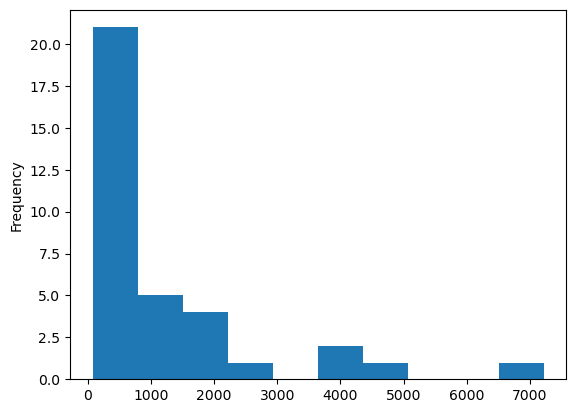

In [63]:
# Pseudo-normalize the elevation column
lab_sj = data_sj.copy()
lab_sj['alt'] = lab_sj['elevation_meters'].apply(lambda x: x/1000)
lab_sj = label_clusters(lab_sj)
_ = lab_sj['cluster'].value_counts().plot.hist()

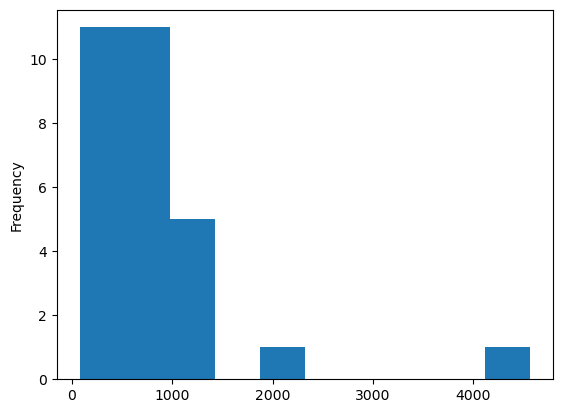

In [7]:
# Pseudo-normalize the elevation column
lab_eg = data_eg.copy()
lab_eg['alt'] = lab_eg['elevation_meters'].apply(lambda x: x/1000)
lab_eg = label_clusters(lab_eg)
_ = lab_eg['cluster'].value_counts().plot.hist()

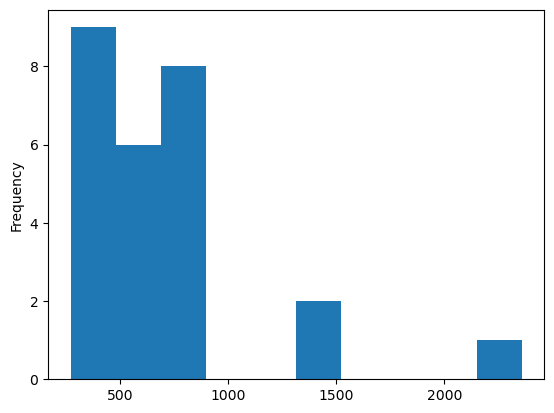

In [8]:
# Pseudo-normalize the elevation column
lab_ch = data_ch.copy()
lab_ch['alt'] = lab_ch['elevation_meters'].apply(lambda x: x/1000)
lab_ch = label_clusters(lab_ch)
_ = lab_ch['cluster'].value_counts().plot.hist()

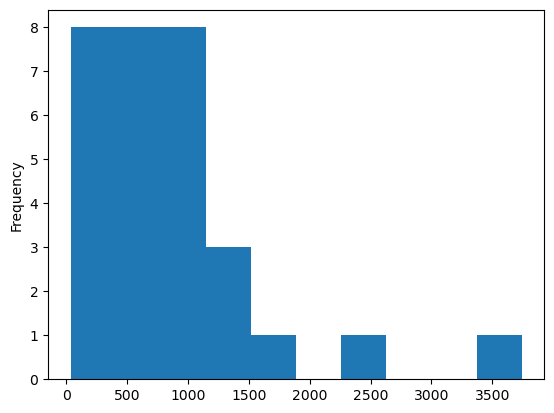

In [9]:
# Pseudo-normalize the elevation column
lab_la = data_la.copy()
lab_la['alt'] = lab_la['elevation_meters'].apply(lambda x: x/1000)
lab_la = label_clusters(lab_la)
_ = lab_la['cluster'].value_counts().plot.hist()

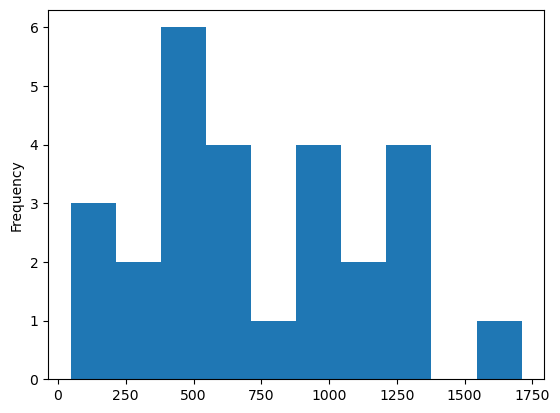

In [10]:
# Pseudo-normalize the elevation column
lab_se = data_se.copy()
lab_se['alt'] = lab_se['elevation_meters'].apply(lambda x: x/1000)
lab_se = label_clusters(lab_se)
_ = lab_se['cluster'].value_counts().plot.hist()

In [11]:
def species_per_cluster(df, by='comName'):
    """
    Takes a df and returns a dict:
        Key: Cluster number
        Val: set of names found in the cluster
    """
    species = {}
    for i in pd.unique(df['cluster']):
        names = set(df[df['cluster'] == i][by])
        species[i] = names
    return species

In [12]:
def get_similarity(df_a, df_b):
    """
    Gets cluster similarity by calculating the set
    similarity of the species names found in each cluster.
    """
    output = []
    sp_a = species_per_cluster(df_a)
    sp_b = species_per_cluster(df_b)
    for k_a, v_a in sp_a.items():
        for k_b, v_b in sp_b.items():
            iou = len(v_a.intersection(v_b)) / len(v_a.union(v_b))
            d = {'A': k_a, 'B': k_b, 'iou': iou}
            output.append(d)
    return pd.DataFrame(output)

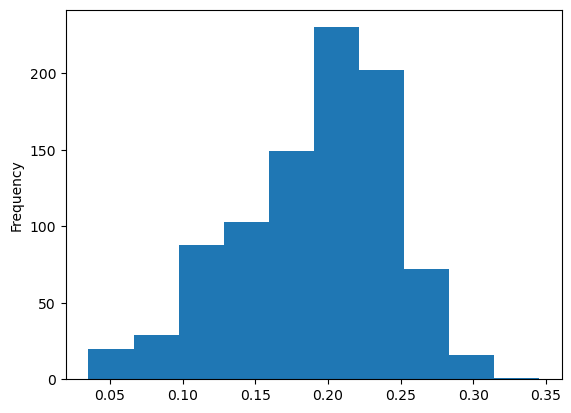

In [13]:
cluster_similarities = get_similarity(
    lab_sj,
    lab_ch
)
_ = cluster_similarities['iou'].plot.hist()

In [14]:
def foo(name, df_src, df_tgt, do_plots=False):
    if name not in df_src['comName'].values:
        raise KeyError('Unable to find species in the source region.')
    print('Is bird already found in the target region?', name in df_tgt['comName'].values)
    
    # find which source clusters the named species occurs in
    src_clusters = np.unique(df_src[df_src['comName'] == name]['cluster'])
    # drop the clusters that the named species doesn't occur in
    df_srcdrop = df_src[df_src['cluster'].isin(src_clusters)]
    # compare species sets
    sims = get_similarity(df_srcdrop, df_tgt)
    
    s_mean = sims['iou'].mean()
    s_std = sims['iou'].std()
    s_max = sims['iou'].max()
    s_z = (s_max - s_mean) / s_std
    a = sims[sims['iou'] == s_max]['A'].item()
    b = sims[sims['iou'] == s_max]['B'].item()
    print('Sub-cluster compatability:', round(s_mean, 2))
    print('Highest similarity:', round(s_max, 2), f'(z {round(s_z, 2)})')

    sightings_a = df_src['cluster'].value_counts()
    sa_mean = sightings_a.mean()
    sa_std = sightings_a.std()
    sa_z = (sightings_a[a] - sa_mean) / sa_std
    print('Source cluster:', a, f'(num sightings z {round(sa_z, 2)})')
    sightings_b = df_tgt['cluster'].value_counts()
    sb_mean = sightings_b.mean()
    sb_std = sightings_b.std()
    sb_z = (sightings_b[b] - sb_mean) / sb_std
    print('Target cluster:', b, f'(num sightings z {round(sb_z, 2)})')

    plots(df_a, do_plots, do_plots)
    plots(df_b, do_plots, do_plots)

In [15]:
bird = "Western Bluebird"
df_a, df_b = lab_la, lab_sj

foo(bird, df_a, df_b)

Is bird already found in the target region? True
Sub-cluster compatability: 0.33
Highest similarity: 0.59 (z 2.53)
Source cluster: 16 (num sightings z 3.85)
Target cluster: 2 (num sightings z 2.22)


In [16]:
bird = "Common Murre"
df_a, df_b = lab_sj, lab_eg

foo(bird, df_a, df_b)

Is bird already found in the target region? False
Sub-cluster compatability: 0.1
Highest similarity: 0.19 (z 2.8)
Source cluster: 1 (num sightings z 3.62)
Target cluster: 12 (num sightings z -0.18)


In [17]:
bird = "Canada Goose"
df_a, df_b = lab_se, lab_ch

foo(bird, df_a, df_b)

Is bird already found in the target region? True
Sub-cluster compatability: 0.25
Highest similarity: 0.4 (z 2.76)
Source cluster: 5 (num sightings z 1.47)
Target cluster: 1 (num sightings z 1.48)
